In [1]:
from math import *
import numpy as np
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import schemdraw
import schemdraw.elements as elm

In [2]:
# File reader which takes in a specified file and decomposes it into lines,
# inputting information into dictionary. Nodes are the keys, and a list of the two coordinates
# become the values for each key.

node_map = {}

with open("final.txt") as f:
    
    # Read in lines
    # Take first line and make it the num_of_nodes
    lines = f.readlines()
    num_of_nodes = f.readline()
    num_of_nodes = lines[0].split()
    num_of_nodes = int(num_of_nodes[0])
    
    #Fill in the node_map, adding node ID for a key and list of node coords for a value.
    for line in lines[1:num_of_nodes + 1]:
        
        nodes = line.split()
        node_map[nodes[0]] = [int(nodes[1]), int(nodes[2])]
    
    # declare num_of_edges by picking up on the line where we left off reading in nodes
    num_of_edges = lines[num_of_nodes + 1].split()
    num_of_edges = int(num_of_edges[0])
        
    # Resistor mapping by getting a list of all of the keys in the dictionary
    def getList(dict):
        return [*dict]
    keys = getList(node_map)    
        
    # Create source node index in list of keys, node coordinate, and it's power
    source_line = lines[num_of_nodes + num_of_edges + 2].split()
    source_node = list(node_map.keys()).index(source_line[0])
    source_coord = node_map[source_line[0]]
    source_power = int(source_line[1])
    
    # Create sink node index in list of keys, and coordinate
    sink_line = lines[num_of_nodes + num_of_edges + 3].split()
    sink_node = list(node_map.keys()).index(sink_line[0])
    sink_coord = node_map[sink_line[0]]
    
print("Node map:",node_map)
print("Num of nodes:", num_of_nodes)
print("Num of edges:", num_of_edges)
print("Source power:", source_power)
print("Source node index:", source_node)
print("Source coord:", source_coord)
print("Sink node index:", sink_node)
print("Sink coord:", sink_coord)

Node map: {'N11': [0, 0], 'N12': [4, 0], 'N13': [8, 0], 'N14': [12, 0], 'N21': [0, -4], 'N22': [4, -4], 'N23': [8, -4], 'N24': [12, -4], 'N31': [0, -8], 'N32': [4, -8], 'N33': [8, -8], 'N34': [12, -8]}
Num of nodes: 12
Num of edges: 23
Source power: 4
Source node index: 2
Source coord: [8, 0]
Sink node index: 9
Sink coord: [4, -8]


### Reading in the node and edge info

In [3]:
# Create a matrix with coordinates of each node, placed in their respective index
# Column 0 is x, column 1 is y. The index of the row specifies which node it is by
# the index in the dictionary.

node_coord = np.zeros((num_of_nodes, 2))
j = 0
for i in node_map:
    node_coord[j] = node_map[i]
    j += 1

# Create a matrix of node connections by reading the edges portion of the text file,
# the node ID's are replaced with the index of the node in the dictionary, and the
# third column is the resistor value along that edge.

node_connection = np.zeros((num_of_edges, 3))
i = 0
for line in lines[num_of_nodes + 2 : num_of_nodes + num_of_edges + 2]:   
    edges = line.split()
    node_connection[i, 0] = int(list(node_map.keys()).index(edges[0]))
    node_connection[i, 1] = int(list(node_map.keys()).index(edges[1]))
    node_connection[i, 2] = int(edges[2])
    i += 1

print(node_connection)

[[ 0.  1.  1.]
 [ 0.  4.  1.]
 [ 0.  5.  1.]
 [ 1.  2.  1.]
 [ 1.  5.  1.]
 [ 1.  6.  1.]
 [ 2.  3.  1.]
 [ 2.  6.  1.]
 [ 2.  7.  1.]
 [ 3.  7.  1.]
 [ 4.  5.  1.]
 [ 4.  8.  1.]
 [ 4.  9.  1.]
 [ 5.  6.  0.]
 [ 5.  9.  1.]
 [ 5. 10.  1.]
 [ 6.  7.  1.]
 [ 6. 10.  1.]
 [ 6. 11.  1.]
 [ 7. 11.  1.]
 [ 8.  9.  0.]
 [ 9. 10.  1.]
 [10. 11.  0.]]


### Setting up the A and R matrices

In [4]:
# Construct the matrix A (node arc incidence matrix) of connections between nodes.
# The columns represent the nodes, the rows represent the edges.

A = np.zeros([num_of_edges, num_of_nodes])
for i in range(A.shape[0]):
    # iteration is the columns of the ith row, so we can get the start node and end node of the edge
    iteration = node_connection[i, :]
    begin = iteration[0]
    end = iteration[1]
    
    # Starting node is negative, ending node is positive. 
    A[i, int(begin)] = -1
    A[i, int(end)] = 1
print(A)


# Matrix R of resistors which expresses the resistances along each edge

R = np.zeros([num_of_edges, num_of_edges])
for i in range(node_connection.shape[0]):
    iteration = node_connection[i]
    # Grab the third value of the iteration list and place it in this matrix as the 
    # value of the resistor
    R[i, i] = iteration[2]
print(R)

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0. -

### Schematic Drawing

Source node: 2 , Source coords: 8 0


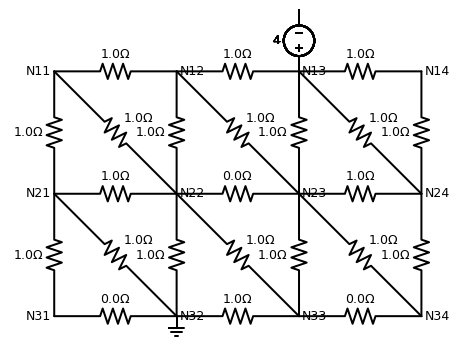

In [5]:
schematic = schemdraw.Drawing()

# Retrieve the x and y coordinates of the source and store them as variables
source_x = source_coord[0]
source_y = source_coord[1]
print("Source node:", source_node, ", Source coords:", source_x, source_y)


# Go through each node in dictionary and add it to the schematic
for i in range(num_of_nodes):
    # Add the source 
    schematic += elm.SourceV().endpoints((source_x, source_y + 2), 
                        (source_x, source_y)).label(str(source_power))
    # If x coord is = 0, the node is placed on the left
    if node_coord[i, 0] == 0:
        direc = 'left'
    # Otherwise it will be placed on the right
    else:
        direc = 'right'
    # Add each node to the schematic by getting its coordinates from the node_coord matrix,
    # and adding its ID from the list of keys in the dictionary (which are node IDs)
    schematic += elm.Line().endpoints((node_coord[i, 0], node_coord[i, 1]), 
                                      (node_coord[i, 0], node_coord[i, 1])).label(str(keys[i]), loc=direc)
schematic += elm.Ground().at(sink_coord)


# Add the resistors to the schematic
for i in range(A.shape[0]):
    startInd = 0
    
    # Loop through each row of A, finding the start and end position of the resistor based on
    # the values of -1 or 1 in the row.
    for j in range(A.shape[1]):
        if A[i, j] == -1:
            start = node_coord[j] #(x,y)
            # Store the index of the starting node for searching for resistance later
            startInd = j
        if A[i, j] == 1:
            end = node_coord[j]
            break
    # Search through the node connections and find the one that matches the start index
    # and end
    for h in range(node_connection.shape[0]):
        if node_connection[h, 0] == startInd:
            if node_connection[h, 1] == j:
                r = node_connection[h, 2]
    schematic += elm.Resistor().endpoints(start, end).label(str(r) + '$\Omega$')
    
schematic.draw()

In [6]:
# Removing the column of the already known source and sink voltages
Ap = np.delete(A, sink_node, 1)
Ap = np.delete(Ap, source_node, 1)

# Construct the right hand side of knowns
rhs = np.array(([A[:,source_node], A[:,sink_node]]))
rhs = -rhs.T

# Account for the knowns on the right hand side (which is source and sink voltage)
knowns = np.array(([source_power, 0]))
rhs = rhs @ knowns.T

# Construct the matrix C consisting of A, A transpose, R, and a zero matrix which will
# be used for solving voltages and currents
C = np.zeros((Ap.shape[0] + Ap.T.shape[0], Ap.shape[1] + R.shape[1]))
for i in range(Ap.shape[0]):
    for j in range(Ap.shape[1]):
        # Place A in the top left
        C[i, j] = Ap[i, j]
        # Place A transpose in the bottom right
        C[j + Ap.shape[0], i + Ap.shape[1]] = Ap[i, j]

# Place R in the top right of the C matrix
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        C[i, j + Ap.shape[1]] = R[i, j]

# Append the extra zeros on to right hand side to match the size of C
while rhs.shape[0] < C.shape[1]:
    rhs = np.append(rhs, 0)

In [7]:
#Solve using SVD
u, s, v = np.linalg.svd(C)
utb = u.T @ rhs
for i in range (C.shape[0]):
    utb[i] /= s[i]

x = v.T @ utb

# Construct the final answer vector, placing the source and sink back
final = x
final = np.insert(final, source_node, source_power, axis=None)
final = np.insert(final, sink_node, 0, axis=None)

# Print out the final answer with correct formatting
# Voltages first
i = 0
for node in node_map:
    print("Node", node, "voltage:", final[i])
    i+= 1
    
# Currents next
i = num_of_nodes
for line in lines[num_of_nodes + 2 : num_of_nodes + num_of_edges + 2]:   
    edges = line.split()
    print(edges[0], "->", edges[1], final[i])
    i += 1

Node N11 voltage: 1.759069340272461
Node N12 voltage: 2.4105311495484467
Node N13 voltage: 4.0
Node N14 voltage: 3.3797642736874343
Node N21 voltage: 0.9251492423082783
Node N22 voltage: 1.941527628960662
Node N23 voltage: 1.941527628960663
Node N24 voltage: 2.759528547374864
Node N31 voltage: 3.247402347028583e-15
Node N32 voltage: 0.0
Node N33 voltage: 1.7168222868513692
Node N34 voltage: 1.7168222868513712
N11 -> N12 -0.6514618092759823
N11 -> N21 0.8339200979641831
N11 -> N22 -0.18245828868819758
N12 -> N13 -1.5894688504515533
N12 -> N22 0.4690035205877843
N12 -> N23 0.4690035205877888
N13 -> N14 0.620235726312567
N13 -> N23 2.058472371039338
N13 -> N24 1.2404714526251324
N14 -> N24 0.6202357263125676
N21 -> N22 -1.0163783866523801
N21 -> N31 0.925149242308279
N21 -> N32 0.9251492423082796
N22 -> N23 -2.896066125822747
N22 -> N32 1.941527628960663
N22 -> N33 0.22470534210929077
N23 -> N24 -0.8180009184142056
N23 -> N33 0.22470534210929136
N23 -> N34 0.22470534210929116
N24 -> N34 1